In [1]:
# Import required libraries
import numpy as np
import pandas as pd
import re
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.feature_selection import mutual_info_regression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.cluster import KMeans
import shap
import random

In [2]:
RANDOM_STATE = 35

In [ ]:
df = pd.read_csv('train.csv', delimiter=',')

In [ ]:
df.head()

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200
1,1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999
2,2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,None reported,Yes,13900
3,3,Genesis,G90 5.0 Ultimate,2017,19500,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,45000
4,4,Mercedes-Benz,Metris Base,2021,7388,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,None reported,Yes,97500


In [ ]:
# Check for missing values
print(f'missing data: {df.isnull().sum()}')

missing data: id                  0
brand               0
model               0
model_year          0
milage              0
fuel_type        5083
engine              0
transmission        0
ext_col             0
int_col             0
accident         2452
clean_title     21419
price               0
dtype: int64


In [3]:
# Make price and milage float for furthur treatment
df['price']=df['price'].astype('float')
df['milage'] = df['milage'].astype('float')

NameError: name 'df' is not defined

In [ ]:
# Treat missing initial categorical variables with mode imputer
def df_missing_cat(df):
    categorical_attributes = df.select_dtypes(include=[int, object]).columns.tolist()
    print(f'categorical attributes: {categorical_attributes}')

    categorical_data_missing = [attr for attr in categorical_attributes if df[attr].isnull().any()]
    print(f'Missing categories: {categorical_data_missing}')

    # Impute categorical features with mode
    mode_imputer = SimpleImputer(strategy='most_frequent')
    df[categorical_data_missing] = mode_imputer.fit_transform(df[categorical_data_missing])

    return df

In [ ]:
df = df_missing_cat(df)

categorical attributes: ['id', 'brand', 'model', 'model_year', 'fuel_type', 'engine', 'transmission', 'ext_col', 'int_col', 'accident', 'clean_title']
Missing categories: ['fuel_type', 'accident', 'clean_title']


In [5]:
# Categorical: Int, object: Won't be scaled and will be applied mode Imputer
# Continuos: Float, float64:  Will be Scaled, applied mean Imputer

In [7]:
### Feature Engineering

In [8]:
Different functions to extract features from original dataset

SyntaxError: invalid syntax (<ipython-input-8-46fe96bfe2f8>, line 1)

In [9]:
# Categorical
def get_automatic(string):
    string = string.lower()
    if 'a/t' in string or 'automatic' in string or 'at' in string:
        return 1
    else:
        return 0

In [10]:
# Categorical
def get_gears(string):
    match = re.search(r'^(\d+)-Speed', string, re.IGNORECASE)
    if match:
        gears = match.group(1)
        return int(gears)
    else:
        return None

In [11]:
# Contiunuos
def get_hp(engine):
    match = re.search(r'([\d.]+)HP', engine, re.IGNORECASE)
    if match:
      return float(match.group(1))
    else:
      return None

In [12]:
# Continuos
def get_L(engine):
    match = re.search(r'([\d.]+)L', engine, re.IGNORECASE)
    if match:
      return float(match.group(1))
    else:
      return None

In [13]:
# Categorical
def get_cyl(engine):
    match = re.search(r'([\d.]+)?\s?(?:Cylinder|Cyl|Cylinders)', engine, re.IGNORECASE)
    if match:
      return int(match.group(1))
    else:
      return None

In [15]:
# Categorical
def is_electric(engine):
    if 'electric' in engine.lower():
      return 1
    else:
      return 0

In [16]:
# Continuos
def num_valves(engine):
    match = re.search(r'([\d+])V', engine)
    if match:
      return float(match.group(1))
    else:
      return None

In [19]:
# Categorical
def is_accident(accident):
    if type(accident) == str:
        if 'accident' in accident.lower():
          return 1
        else:
          return 0
    else:
        return None

In [ ]:
Following functions takes a dataframe, extracts features within it.

In [20]:
# Create ratios
def create_features(df):
    ''' Returns dataframe with newly created features '''
    df['automatic'] = df['transmission'].apply(get_automatic)
    df['gears'] = df['transmission'].apply(get_gears)
    df['hp'] = df['engine'].apply(get_hp)
    df['L'] = df['engine'].apply(get_L)
    df['cylinders'] = df['engine'].apply(get_cyl)
    df['accident'] = df['accident'].apply(is_accident)
    df['electric'] = df['engine'].apply(is_electric)
    df['valves'] = df['engine'].apply(num_valves)
    return df

def create_interactions(df):
    ''' Returns dataframe with newly created interaction features'''
    df['hp/l'] = np.where(df['L'] != 0, df['hp'] / df['L'], None).astype('float')
    df['mil/l'] = np.where(df['L'] != 0, df['milage'] / df['L'], None).astype('float')
    df['mil/hp'] = np.where(df['hp'] != 0, df['milage'] / df['hp'], None).astype('float')
    df['l/cyl'] = np.where(df['cylinders'] != 0, df['L'] / df['cylinders'], None).astype('float')
    df['hp/gears'] = np.where(df['gears'] != 0, df['hp'] / df['gears'], None).astype('float')
    df['mil/gears'] = np.where(df['gears'] != 0, df['milage'] / df['gears'], None).astype('float')
    df['mil/cyl'] = np.where(df['cylinders'] != 0, df['milage'] / df['cylinders'], None).astype('float')

    df['hp*automatic'] = df['hp'] * df['automatic']
    df['cyl*gears'] = df['cylinders'] * df['gears']

    df['carAge'] = df['model_year'] - 2024
    df['mil/year'] = np.where(df['carAge'] != 0, df['milage'] / df['carAge'], None).astype('float')
    df['hp*accident'] = df['hp'] * df['accident']
    df['accident*carAge'] = df['accident'] * df['carAge']
    df['acc*milage'] = df['accident'] * df['milage']

    df['mil*carAge'] = df['milage'] * df['carAge']
    df['hp*mil'] = df['hp'] * df['milage']
    return df

In [ ]:
df = create_features(df)

In [ ]:
# Create a list to track categorical variables
# We will treat some suitable variables as categorical
new_categoricals = list(df.select_dtypes(include=[int, object]).columns)
new_categoricals.extend(['L', 'cylinders', 'gears'])
new_categoricals.remove('id')
new_categoricals

['id',
 'brand',
 'model',
 'model_year',
 'fuel_type',
 'engine',
 'transmission',
 'ext_col',
 'int_col',
 'accident',
 'clean_title',
 'automatic',
 'electric',
 'L',
 'cylinders',
 'gears']

### Treat missing values of variables

In [ ]:
print(df.isnull().sum())

id                   0
brand                0
model                0
model_year           0
milage               0
fuel_type            0
engine               0
transmission         0
ext_col              0
int_col              0
accident             0
clean_title          0
price                0
automatic            0
gears            84434
hp               33259
L                14214
cylinders        37855
electric             0
valves          165115
dtype: int64


In [ ]:
# Treat categorical missing values
def df_missing_new_cat(df, new_categoricals):
    ''' Applies mode imputer to categorical missing values '''
    categorical_features_missing = [col for col in new_categoricals if df[col].isnull().any()]
    print(f'Categorical missing features: {categorical_features_missing}')

    mode_imputer = SimpleImputer(strategy='most_frequent')
    df[categorical_features_missing] = mode_imputer.fit_transform(df[categorical_features_missing])
    return df

In [ ]:
df = df_missing_new_cat(df, new_categoricals)
print(df.isnull().sum())

Categorical missing features: ['L', 'cylinders', 'gears']
id                   0
brand                0
model                0
model_year           0
milage               0
fuel_type            0
engine               0
transmission         0
ext_col              0
int_col              0
accident             0
clean_title          0
price                0
automatic            0
gears                0
hp               33259
L                    0
cylinders            0
electric             0
valves          165115
dtype: int64


In [ ]:
# Treat continuos missing values
def df_missing_cont(df, new_categoricals):
    ''' Applies mean imputer to continuos variables with missing values '''
    continuos_features_missing = [col for col in df.columns if col not in new_categoricals and df[col].isnull().any()]
    print(f'Missing continuos features: {continuos_features_missing}')

    mean_imputer = SimpleImputer(strategy='mean')
    df[continuos_features_missing] = mean_imputer.fit_transform(df[continuos_features_missing])
    return df

In [ ]:
df = df_missing_cont(df, new_categoricals)

Missing continuos features: ['hp', 'valves']


In [ ]:
print( df.isnull().sum())

id              0
brand           0
model           0
model_year      0
milage          0
fuel_type       0
engine          0
transmission    0
ext_col         0
int_col         0
accident        0
clean_title     0
price           0
automatic       0
gears           0
hp              0
L               0
cylinders       0
electric        0
valves          0
dtype: int64


### Create Interaction features

In [1]:
# Create interaction features
df = create_interactions(df)

NameError: name 'create_interactions' is not defined

In [2]:
# See milage distribution
plt.hist(df['milage'], bins=200)
plt.show();

# milage is right skewed. Log transformation could be used.
log_milage = np.log(df['milage'])
plt.hist(log_milage, bins=200)
plt.show()

NameError: name 'plt' is not defined

In [ ]:
# Add binning to milage and categorize ordinally

# Get range of values
print(np.min(df['milage']), np.max(df['milage']))

bins = [99.0, 1000.0, 10000.0, 50000.0, 100000.0, 300000.0, 500000.0]

binned_milage = pd.cut(df['milage'], bins, right=False)

# mils_bins_category is dict of structure {interval: int} where int is increasing from 0 to 5: there are 6 Intervals
mils_bins_category = {}
for i in range(0, len(bins) - 1, 1):
    mils_bins_category[pd.Interval(bins[i], bins[i+1], closed='left')] = i

100.0 405000.0


In [ ]:
# Assign classes to brands according to their mean prices
# Classes are of type int, ordinally categorized

# Get range of values
print(np.min(df['price']), np.max(df['price']))

bins = [1000.0, 5000.0, 10000.0, 25000.0, 50000.0, 100000.0, 150000.0, 200000.0, 250000.0, 300000.0]

binned_prices = pd.cut(df['price'], bins, right=False) # 9 Intervals

# Create bins category mapping
bins_category = {pd.Interval(bins[i], bins[i+1], closed='left'): i for i in range(len(bins) - 1)}

# Create dict {'brand_name' : mean_price}
brand_avg_price = df.groupby('brand')['price'].mean().to_dict()


def get_class(mprice):
    ''' Returns category of mean price
    Args:
    mprice(float) : Mean price
    Returns:
    category(int): Category of interval in which mrice lies
    '''

    for interval, category in bins_category.items():
        if mprice in interval:
          return category

In [ ]:
def additional_features(df):
    df['AverageMilage'] = df.groupby("brand")['milage'].transform('mean')
    df['BrandFreq'] = df.groupby('brand')['brand'].transform('count')/df['brand'].count()

    brand_count = df.groupby('brand')['brand'].count().to_dict() #{'brand_name' : mean_price}
    df['brand_count'] = df['brand'].map(brand_count)

    brand_avg_mil = df.groupby('brand')['milage'].mean().to_dict() #{'brand_name' : mean_price}
    df['brand_avg_mil'] = df['brand'].map(brand_avg_mil)

    df['binned_milage'] = binned_milage.map(lambda x: mils_bins_category[x])

    brand_class = {brand: get_class(price) for brand, price in brand_avg_price.items()}
    df['brand_class'] = df['brand'].map(lambda x: brand_class[x])

    df['log_milage'] = np.log(df['milage'])


    return df

In [ ]:
df = additional_features(df)

In [ ]:
'''from category_encoders import BinaryEncoder
binaries = BinaryEncoder(cols=objects, drop_invariant=True).fit_transform(df)
df = df.join(binaries, rsuffix='_encoded')
df.columns'''

"from category_encoders import BinaryEncoder\nbinaries = BinaryEncoder(cols=objects, drop_invariant=True).fit_transform(df)\ndf = df.join(binaries, rsuffix='_encoded')\ndf.columns"

In [ ]:
# Check for missing values
print(df.isnull().sum())

id                   0
brand                0
model                0
model_year           0
milage               0
fuel_type            0
engine               0
transmission         0
ext_col              0
int_col              0
accident             0
clean_title          0
price                0
automatic            0
gears                0
hp                   0
L                    0
cylinders            0
electric             0
valves               0
hp/l                 0
mil/l                0
mil/hp               0
l/cyl                0
hp/gears             0
mil/gears            0
mil/cyl              0
hp*automatic         0
cyl*gears            0
carAge               0
mil/year           162
hp*accident          0
accident*carAge      0
acc*milage           0
mil*carAge           0
hp*mil               0
AverageMilage        0
BrandFreq            0
brand_count          0
brand_avg_mil        0
binned_milage        0
brand_class          0
log_milage           0
dtype: int6

In [ ]:
df = df_missing_cont(df, new_categoricals)

Missing continuos features: ['mil/year']


In [ ]:
print(df.isnull().sum())

id                 0
brand              0
model              0
model_year         0
milage             0
fuel_type          0
engine             0
transmission       0
ext_col            0
int_col            0
accident           0
clean_title        0
price              0
automatic          0
gears              0
hp                 0
L                  0
cylinders          0
electric           0
valves             0
hp/l               0
mil/l              0
mil/hp             0
l/cyl              0
hp/gears           0
mil/gears          0
mil/cyl            0
hp*automatic       0
cyl*gears          0
carAge             0
mil/year           0
hp*accident        0
accident*carAge    0
acc*milage         0
mil*carAge         0
hp*mil             0
AverageMilage      0
BrandFreq          0
brand_count        0
brand_avg_mil      0
binned_milage      0
brand_class        0
log_milage         0
dtype: int64


In [ ]:
# Label categorical features
for colname in new_categoricals:
    df[colname], _ = df[colname].factorize()

In [ ]:
X = df.copy()
y = X.pop('price')

In [3]:
X.pop('id')

NameError: name 'X' is not defined

#### PCA

In [ ]:
# Standardize the data (important for PCA)
scaler_pca = StandardScaler()
X_scaled = scaler_pca.fit_transform(X.select_dtypes(include='float'))

# Apply PCA
pca = PCA(n_components=2)  # Specify the number of components
pca_components = pca.fit_transform(X_scaled)

# Explained Variance
explained_variance = np.sum(pca.explained_variance_ratio_)

print("Explained Variance Ratio:", explained_variance)

# Convert to DataFrame for better readability
pca_df = pd.DataFrame(data=pca_components, columns=['PC1', 'PC2'])
X = pd.concat([X, pca_df], axis=1)

Explained Variance Ratio: 0.4938634990185205


,PC1,PC2
0,9.643746,-0.711566
1,4.644826,0.199902
2,2.902616,-0.100479
3,-2.824303,-0.373584
4,-2.727159,0.704619
...,...,...
188528,-0.817555,1.422266
188529,-2.008748,-0.854601
188530,-3.485678,-0.623001
188531,-2.443784,-2.246261


#### K-means Clustering

In [6]:
# Add cluster feature
c_scaler = StandardScaler()
XC = [col for col in X.columns if col not in new_categoricals]
XC = X[XC]
XC = c_scaler.fit_transform(XC)

# Create cluster feature
kmeans = KMeans(n_clusters=3, n_init=10)
X['Cluster'] = kmeans.fit_predict(XC)
X['Cluster'] = X['Cluster'].astype('category')

NameError: name 'StandardScaler' is not defined

#### Output of a trained NN as feature

In [ ]:

tf_model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(1),
]
)

tf_model.compile(loss='mse', optimizer='adam')

history = tf_model.fit(X, y, epochs = 10)


Epoch 1/10
5892/5892 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - loss: 6176701952.0000
Epoch 2/10
5892/5892 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step - loss: 5699938304.0000
Epoch 3/10
5892/5892 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - loss: 5899531264.0000
Epoch 4/10
5892/5892 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - loss: 5567848448.0000
Epoch 5/10
5892/5892 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - loss: 5381576192.0000
Epoch 6/10
5892/5892 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - loss: 6128227840.0000
Epoch 7/10
5892/5892 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - loss: 5280883712.0000
Epoch 8/10
5892/5892 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - loss: 5741238784.0000
Epoch 9/10
5892/5892 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - loss: 4945702912.0000
Epoch 10/10
5892/5892 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - loss: 5246514688.0000


In [ ]:
r_model = Ridge(alpha=1)
r_model.fit(X, y)
np.sqrt(mean_squared_error(r_model.predict(X), y))

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.74784e-20): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


73564.09027549427

In [ ]:
#X['f1'] = tf_model.predict(X)
X['f1'] = r_model.predict(X)

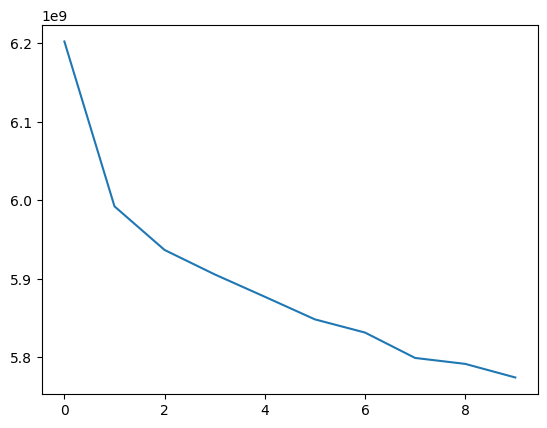

In [ ]:
plt.plot(history.history['loss'])

In [ ]:
X.shape

(188533, 45)

# Features selection

### Calculate MI scores

In [ ]:
discrete_features = X.select_dtypes(include=[int, 'category'])
discrete_features = np.array([col in discrete_features for col in X.columns])
X.columns[discrete_features]

Index(['brand', 'model', 'model_year', 'fuel_type', 'engine', 'transmission',
       'ext_col', 'int_col', 'accident', 'clean_title', 'automatic', 'gears',
       'L', 'cylinders', 'electric', 'carAge', 'accident*carAge',
       'brand_count', 'binned_milage', 'brand_class', 'Cluster'],
      dtype='object')

In [ ]:
def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores
print(X.shape)
print(y.shape)
mi_scores = make_mi_scores(X, y, discrete_features)

(188533, 44)
(188533,)


In [ ]:
mi_scores

,MI Scores
log_milage,0.659572
milage,0.659429
engine,0.627334
mil*carAge,0.615094
mil/cyl,0.596306
mil/gears,0.590236
hp/l,0.576262
mil/hp,0.546924
model_year,0.541241
carAge,0.541241


In [ ]:
mi_features = list(mi_scores.index)
mi_features[:16]

['log_milage',
 'milage',
 'engine',
 'mil*carAge',
 'mil/cyl',
 'mil/gears',
 'hp/l',
 'mil/hp',
 'model_year',
 'carAge',
 'hp',
 'hp/gears',
 'PC1',
 'mil/l',
 'model',
 'hp*automatic']

### RFE select features

In [ ]:
from sklearn.feature_selection import RFE

# Recursive Feature Elimination
model = XGBRegressor(learning_rate= 0.2,
                     max_depth = 2,
                     n_estimators = 200,)
selector = RFE(model, n_features_to_select=20)
selector.fit(X, y)

# Check selected features
print(selector.support_)


[ True False  True False False False  True False False False False False
 False  True False False False  True False  True  True  True False False
  True False False  True False False  True False  True  True  True  True
 False False False  True False  True  True  True  True]


In [ ]:
rfe_features = list(X.columns[list(selector.support_)])
rfe_features

['brand',
 'model_year',
 'transmission',
 'hp',
 'valves',
 'mil/l',
 'mil/hp',
 'l/cyl',
 'mil/cyl',
 'carAge',
 'accident*carAge',
 'mil*carAge',
 'hp*mil',
 'AverageMilage',
 'BrandFreq',
 'brand_class',
 'PC1',
 'PC2',
 'Cluster',
 'f1']

In [ ]:
# Include features from both MI scores and RFE features
selected_features = list(set(rfe_features) | set(mi_features[:10]))
selected_features = ['hp*mil',
 'AverageMilage',
 'BrandFreq',
 'brand_class',
 'PC1',
 'PC2',
 'Cluster',
 'f1', 'log_milage',
 'milage',
 'engine',
 'mil*carAge',
 'mil/cyl',
 'mil/gears',
 'hp/l',
 'mil/hp',
 'model_year',
 'carAge',
 'hp',
 'hp/gears']

#### Grid search for parameter values for model

In [ ]:
# Used to get params of model
'''# Set up the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [2, 3, 5]
}

# Create the model and GridSearch object
model = XGBRegressor()
grid_search = GridSearchCV(model, param_grid, cv=3)

# Fit to the training data
grid_search.fit(X, y)

# Best hyperparameters
print(grid_search.best_params_)'''

"# Set up the parameter grid\nparam_grid = {\n    'n_estimators': [50, 100, 200],\n    'learning_rate': [0.01, 0.1, 0.2],\n    'max_depth': [2, 3, 5]\n}\n\n# Create the model and GridSearch object\nmodel = XGBRegressor()\ngrid_search = GridSearchCV(model, param_grid, cv=3)\n\n# Fit to the training data\ngrid_search.fit(X, y)\n\n# Best hyperparameters\nprint(grid_search.best_params_)"

In [ ]:
params = {'learning_rate': 0.2, 'max_depth': 2, 'n_estimators': 200}

In [ ]:
model = XGBRegressor(learning_rate= 0.2,
                     max_depth = 2,
                     n_estimators = 200,)

In [ ]:
def get_error(model, x_train, x_cv, y_train, y_cv):
    ypred = model.predict(x_train)
    xgb_train_mse = mean_squared_error(y_train, ypred)
    xgb_train_mse = np.sqrt(xgb_train_mse)

    ypred = model.predict(x_cv)
    xgb_cv_mse = mean_squared_error(y_cv, ypred)
    xgb_cv_mse = np.sqrt(xgb_cv_mse)

    print(f'train MSE: {xgb_train_mse}\nValidation MSE: {xgb_cv_mse}')
    print(f'Difference: {abs(xgb_train_mse - xgb_cv_mse):.4f}')

In [ ]:
# Choose features to use based on MI score
def run_model(X, y, selected_features):
    '''
    Runs selected features on model, returns and plots training and validation MSEs
    '''
    train_mse = []
    val_mse = []
    m, n = X.shape

    N = range(1, len(selected_features))

    for n in N:
        x = X[selected_features[:n]]

        x_train, x_cv, y_train, y_cv = train_test_split(x, y, test_size=0.3, random_state=RANDOM_STATE)

        # Scale Training data
        scaler1 = StandardScaler()
        x_train = scaler1.fit_transform(x_train)
        x_cv = scaler1.transform(x_cv)

        model = XGBRegressor(learning_rate= 0.2,
                        max_depth = 2,
                        n_estimators = 200,)
        model.fit(x_train, y_train)

        ypred = model.predict(x_train)
        xgb_train_mse = mean_squared_error(y_train, ypred)
        train_mse.append(np.sqrt(xgb_train_mse))

        ypred = model.predict(x_cv)
        xgb_cv_mse = mean_squared_error(y_cv, ypred)
        val_mse.append(np.sqrt(xgb_cv_mse))


    plt.close('all')
    plt.plot(N, train_mse, c='r', label='training MSE')
    plt.plot(N, val_mse, c='b', label='Val MSE')
    plt.xlabel('Number of features')
    plt.ylabel('MSEs')
    plt.legend()
    plt.show()

    return train_mse, val_mse

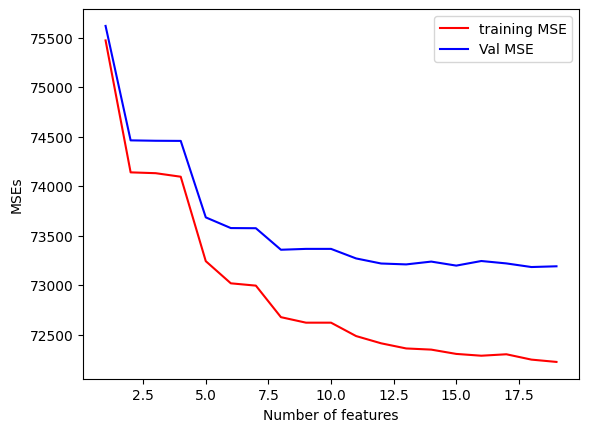

In [ ]:
t , v = run_model(X, y, selected_features)

(72150.98862038495, 73074.10297635733)

# Training

In [ ]:
# Select features from MI score
# X_train = X[mi_features[:9]]

# Select features from RFE selector
X_train = X[rfe_features]

# Select features from selected features
#X_train = X[selected_features[:8]]

# From RFE
#x = X[selected_features]
X_train.shape

(188533, 8)

In [ ]:
# Split dataset into training, validation and testing subsets
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y, test_size=0.3, random_state=RANDOM_STATE)

print(X_train.shape, y_train.shape)

(131973, 8) (131973,)


In [ ]:
# Scale continuos features
continuos_features_to_scale = [col for col in X_train.columns if col not in new_categoricals]
print(f'Features to be scaled: {continuos_features_to_scale}')

scalerTrain = StandardScaler()
x_train = scalerTrain.fit_transform(X_train[continuos_features_to_scale])
x_cv = scalerTrain.transform(X_cv[continuos_features_to_scale])

Features to be scaled: ['hp*mil', 'AverageMilage', 'BrandFreq', 'brand_class', 'PC1', 'PC2', 'Cluster', 'f1']


In [ ]:
# Train model
model.fit(x_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.2, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=2, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [ ]:
# Calculate RMSE
ypred = model.predict(x_train)
xgb_train_mse = mean_squared_error(y_train, ypred)
np.sqrt(xgb_train_mse)

72675.81580668868

In [ ]:
# Evaluate model
get_error(model, x_train, x_cv, y_train, y_cv)

train MSE: 72675.81580668868
Validation MSE: 73356.91298639236
Difference: 681.0972


In [ ]:
'''xgb_model = XGBRegressor(
n_estimators=200,
max_depth=3,
learning_rate=0.01,
)

xgb_model.fit(x_train_mapped, y_train)'''

### Submission

In [ ]:
test = pd.read_csv('test.csv')
id = test.pop('id')

In [ ]:
test = df_missing_cat(test)
test = create_features(test)
test = df_missing_new_cat(test, new_categoricals)
test = df_missing_cont(test, new_categoricals)
test = create_interactions(test)
test = additional_features(test)
test = df_missing_cont(test, new_categoricals)

categorical attributes: ['brand', 'model', 'model_year', 'fuel_type', 'engine', 'transmission', 'ext_col', 'int_col', 'accident', 'clean_title']
Missing categories: ['fuel_type', 'accident', 'clean_title']
Categorical missing features: ['L', 'cylinders', 'gears']
Missing continuos features: ['hp', 'valves']
Missing continuos features: ['mil/year']


In [ ]:
for colname in new_categoricals:
    test[colname], _ = test[colname].factorize()

In [ ]:
test_scaled = scaler_pca.transform(test.select_dtypes(include='float'))
pca_components = pca.transform(test_scaled)

pca_df = pd.DataFrame(data=pca_components, columns=['PC1', 'PC2'])
test = pd.concat([test, pca_df], axis=1)

In [ ]:
#c_scaler = StandardScaler()
XC = [col for col in test.columns if col not in new_categoricals]
XC = test[XC]
XC = c_scaler.transform(XC)

# Create cluster feature
#kmeans = KMeans(n_clusters=3, n_init=10)
test['Cluster'] = kmeans.fit_predict(XC)
test['Cluster'] = test['Cluster'].astype('category')

In [ ]:
'''# Get linear feature from linear model
test['linear_feature'] = lr_model.predict(test)'''

"# Get linear feature from linear model\ntest['linear_feature'] = lr_model.predict(test)"

In [ ]:
x_test = test[rfe_features]
continuos_features_to_scale = [col for col in x_test.columns if col not in new_categoricals]
print(f'Features to be scaled: {continuos_features_to_scale}')

x_test = scalerTrain.transform(x_test[continuos_features_to_scale])

Features to be scaled: ['hp', 'valves', 'hp/l', 'mil/l', 'mil/hp', 'l/cyl', 'mil/gears', 'mil/cyl', 'carAge', 'accident*carAge', 'mil*carAge', 'AverageMilage', 'BrandFreq', 'brand_class', 'PC1', 'PC2']


In [ ]:
pred = model.predict(x_test)

In [ ]:
submision = pd.DataFrame({'id': id, 'price': pred})
submision.to_csv('submission.csv', index=False)

In [ ]:
submision.head()

,id,price
0,188533,19672.046875
1,188534,52789.226562
2,188535,46481.320312
3,188536,38166.535156
4,188537,37252.714844


from matplotlib import pyplot as plt
_df_0['id'].plot(kind='hist', bins=20, title='id')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['price'].plot(kind='hist', bins=20, title='price')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2.plot(kind='scatter', x='id', y='price', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['id']
  ys = series['price']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_3.sort_values('id', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('id')
_ = plt.ylabel('price')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['id']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'id'}, axis=1)
              .sort_values('id', ascending=True))
  xs = counted['id']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_4.sort_values('id', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('id')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_5['id'].plot(kind='line', figsize=(8, 4), title='id')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_6['price'].plot(kind='line', figsize=(8, 4), title='price')
plt.gca().spines[['top', 'right']].set_visible(False)